# Aktywne uczenie
Olga Krupa, Kinga Kwoka

### Środowisko wykonawcze

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
!pip install modAL-python
!pip install ucimlrepo


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [ ]:
%%bash
git clone https://github.com/kzkwoka/active_learning_module.git
git checkout dev

In [ ]:
%cd active_learning_module

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import math

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification

from src.active import ActiveModule
from src.strategies import *
from src.utils import *

## Syntetyczny (sklearn.datasets.make_classification)

### Zbiór danych

In [4]:
X,y = make_classification(
    n_samples=5000,
    n_features=10,
    n_informative=6,
    n_classes=4,
    weights=[0.3,0.1,0.5,0.1],
    n_clusters_per_class=1,
    class_sep=1,
    hypercube=True,
    random_state=42)

In [5]:
from sklearn.decomposition import PCA

df = pd.DataFrame(X)
# df["label"] = y
pcom = PCA(n_components=2).fit_transform(df)

<Axes: xlabel='X', ylabel='Y'>

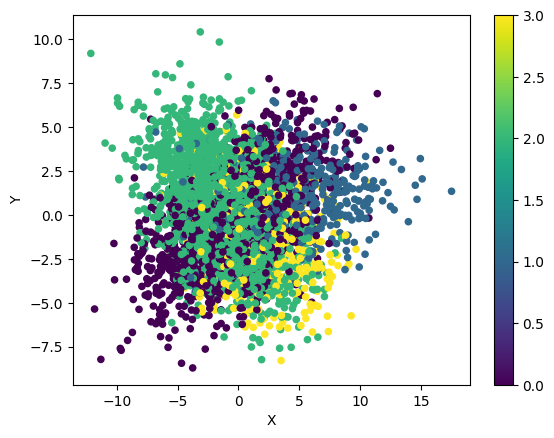

In [6]:
df = pd.concat([pd.DataFrame(pcom),pd.Series(y)], axis=1)
df.columns = ["X","Y","color"]
df.plot(kind='scatter', x="X",y="Y", color=df["color"], colormap='viridis')

### Wstępne przetwarzanie

In [7]:
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)

### Losowy zbiór początkowy

In [18]:
np.random.seed(42)
initial_idx = np.random.randint(low=0, high=X_train.shape[0], size=int(0.1*X_train.shape[0]))

### Ocena na całym zbiorze danych

In [19]:
t = SVC(probability=True, random_state=42)
t.fit(X_train, y_train)
y_pred = t.predict(X_test)

In [20]:
lbin = LabelBinarizer().fit(y_train)
matrix, matrix_pred = lbin.transform(y_test), lbin.transform(y_pred)
benchmark = {
    'default_metric': t.score(X_test, y_test),
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred, average='macro'),
    'recall': recall_score(y_test, y_pred, average='macro'),
    'f1': f1_score(y_test, y_pred, average='macro'),
    'roc_auc': roc_auc_score(matrix, matrix_pred),
    'pr_auc': average_precision_score(matrix, matrix_pred),
    'confusion_matrix': confusion_matrix(y_test, y_pred)
}

In [21]:
{key: round(value,3) for key, value in benchmark.items() if key in ('accuracy', 'roc_auc', 'pr_auc')}

{'accuracy': 0.927, 'roc_auc': 0.927, 'pr_auc': 0.829}

### Aktywne uczenie

In [22]:
learner = ActiveModule(estimator=SVC,
                       X=X_train,
                       y_initial=y_train[initial_idx],
                       label_idx=initial_idx,
                       X_valid=X_test,
                       y_valid=y_test,
                       probability=True,
                       random_state=42)

In [23]:
n_samples = 500
n_iter = math.ceil((X_train.shape[0] - initial_idx.shape[0])/n_samples)

In [24]:
metrics, info = run_experiments(learner, y_train, [random_sampling, uncertainty_sampling, kmeans_plus_plus_sampling], n_samples, n_iter)

100%|██████████| 3/3 [00:06<00:00,  2.24s/it]


In [25]:
for i in info:
    print(i)

One training loop with random_sampling takes approx. 0.27s
One training loop with uncertainty_sampling takes approx. 0.25s
One training loop with kmeans_plus_plus_sampling takes approx. 0.32s


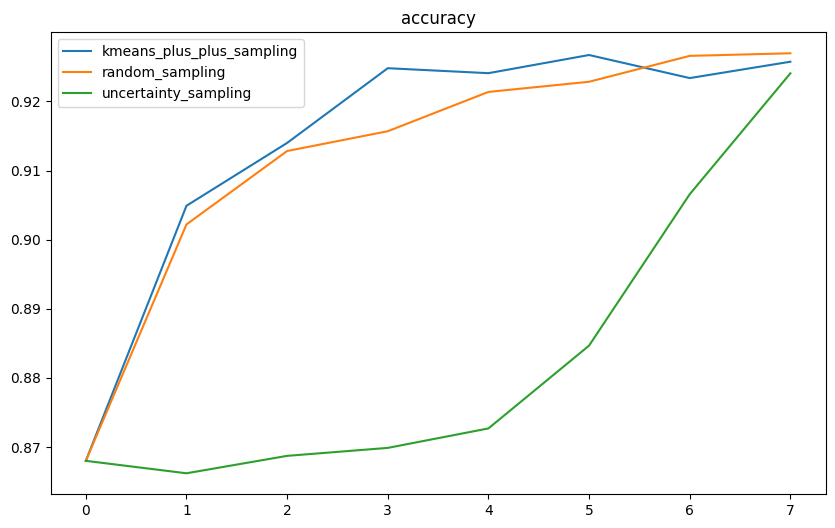

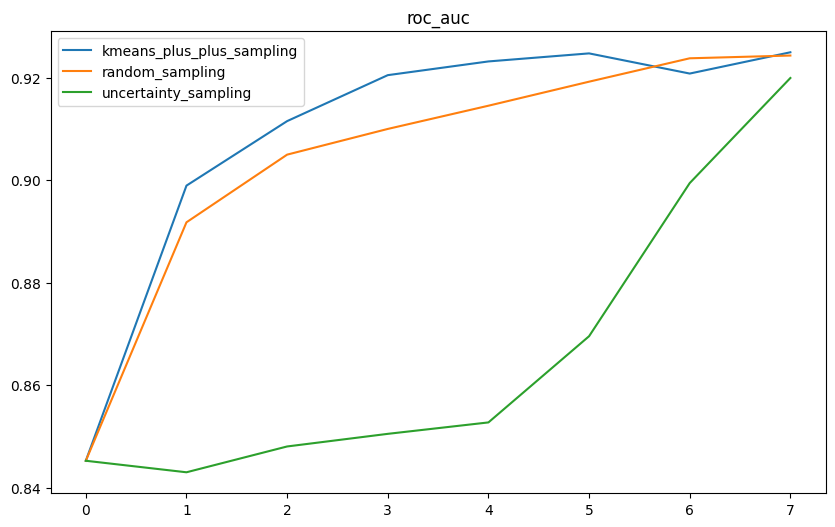

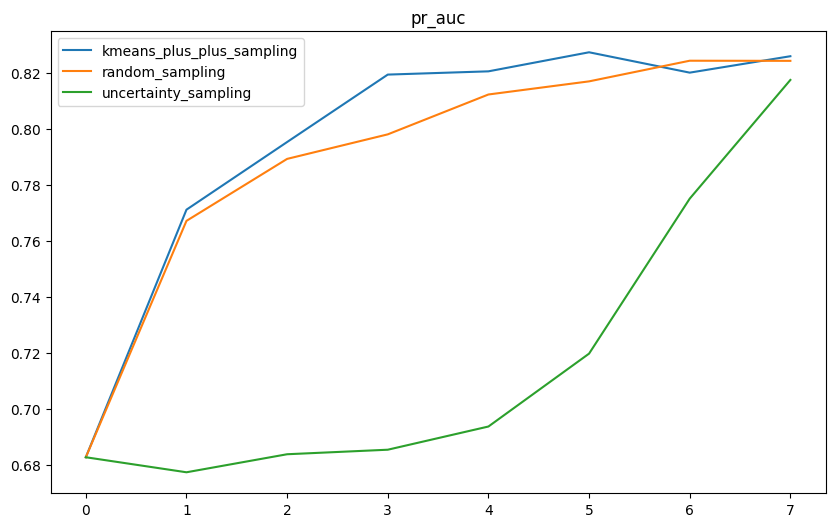

In [26]:
for metric in ["accuracy", "roc_auc", "pr_auc"]:
    fig, ax = plt.subplots(figsize=(10, 6))
    for strategy, df in metrics.groupby('strategy'):
        ax.plot(df.index.get_level_values(1), smooth(df[metric],0.1), label=f'{strategy}')
    plt.legend()
    plt.title(metric)
    plt.show()